In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib widget
sys.path.append('..')
from detectors.feature_based import *
from detectors.pca_based import *
from detectors.gaussian_distribution_based import *
from detectors.ml_based import *

## Setup

In [2]:
data_type = 'bridge' # 'ecg' 'bridge'



In [3]:
if data_type == 'ecg':
    n = 256
    SNRdB = 40
    # set anomaly
    anomaly = 'arrhythmia'
    patient = '101'
    trace_path = os.path.join('..', 'datasets', data_type, f'trace-anomalies-patient={patient}.pkl')
    instances_path = os.path.join('..', 'datasets', data_type, f'instances-anomalies-patient={patient}.pkl')
    time_anomaly = pd.Timedelta(minutes=2, seconds=55) # 'arrhythmia'

    # set detectors
    path_train = os.path.join('..', 'datasets', data_type, f'ecgSyn_n={n}_scaled_train_snr={SNRdB}dB.pkl')
    nu = 0.01
    kernel = 'poly'
    h = 5
    l = 250
    k = 52
    
elif data_type == 'bridge':
    n = 100
    channel = 'x'
    anomaly = 'earthquake'
    trace_path = os.path.join(
    '..', 'datasets', 'bridge',
    f'timeseries-{anomaly}-sensor=1D30-period=2017-11-19 00:00:00-2017-11-19 23:59:59-ch=x_y_z-n={n}-fs=100.pkl')
    instances_path = os.path.join(
    '..', 'datasets', 'bridge',
    f'instances-{anomaly}-sensor=1D30-period=2017-11-19 00:00:00-2017-11-19 23:59:59-ch=x_y_z-n={n}-fs=100-mode=channel-test.pkl')
    time_anomaly = pd.Timestamp('2017-11-19 12:37:50', tz='UTC') # 'earthquake'
    # set detectors
    nu = 0.01
    kernel = 'rbf'
    h = 5
    l = 500
    k = 16 
    path_train = os.path.join('..', 'datasets', data_type, f'instances-sensor=1D30-period=2017-10-02 00:00:00-2017-10-08 23:59:59-ch=x_y_z-n={n}-fs=100-mode=channel-train.pkl')
    

## Load and process anomalous data

In [4]:
X_anom_series = pd.read_pickle(trace_path).dropna(axis=0)
X_anom_instances = pd.read_pickle(instances_path).dropna(axis=0)
if data_type == 'bridge':
    X_anom_series = X_anom_series[channel]
    index = np.array(X_anom_instances.index)
    X_anom = X_anom_instances[channel].values
    new_shape = (-1, 1, X_anom.shape[1])
    X_anom = X_anom.reshape(new_shape)
    X_anom = X_anom.swapaxes(1, 2)
    X_anom = X_anom[..., 0]
if data_type == 'ecg':
    X_anom = X_anom_instances.values
    index = X_anom_instances.index

## Init detectors

In [5]:
# Load and process training data
ninst = 1_000
Xok_train = pd.read_pickle(path_train).dropna(axis=0)
Xok_train = Xok_train.values[:ninst, 0:n].reshape((ninst, -1))

In [6]:
p = 4
detectors_labels = [f'SPE_{k}', f'T2_{k}', f'AR_4', f'OCSVM_{kernel}_{nu}', f'LOF_{h}',f'IF_{l}', 'MD', 'energy', 'TV', 'ZC', 'pk-pk']
detectors = [SPE(k), T2(k), AR(p), OCSVM(kernel, nu), LOF(h), IF(l), MD(), energy(), TV(), ZC(), pk_pk()]
detectors_dict = dict(zip(detectors_labels, detectors))

## Train and evaluate detectors

In [7]:
scores_df = pd.DataFrame(index=index, columns=detectors_labels, dtype=np.float64)
for name, detector in detectors_dict.items():
    scores_df[name] = detector.fit(Xok_train).score(X_anom)

In [8]:
if data_type=='bridge':
    show_period = [time_anomaly - pd.Timedelta(seconds=30), time_anomaly + pd.Timedelta(seconds=30)]
elif data_type=='ecg':
    show_period = [time_anomaly - pd.Timedelta(seconds=10), time_anomaly + pd.Timedelta(seconds=10)]
scores_sliced_df = scores_df.loc[show_period[0]: show_period[1]]
scores_sliced_df.index.freq = pd.tseries.frequencies.to_offset(pd.infer_freq(scores_df.index))

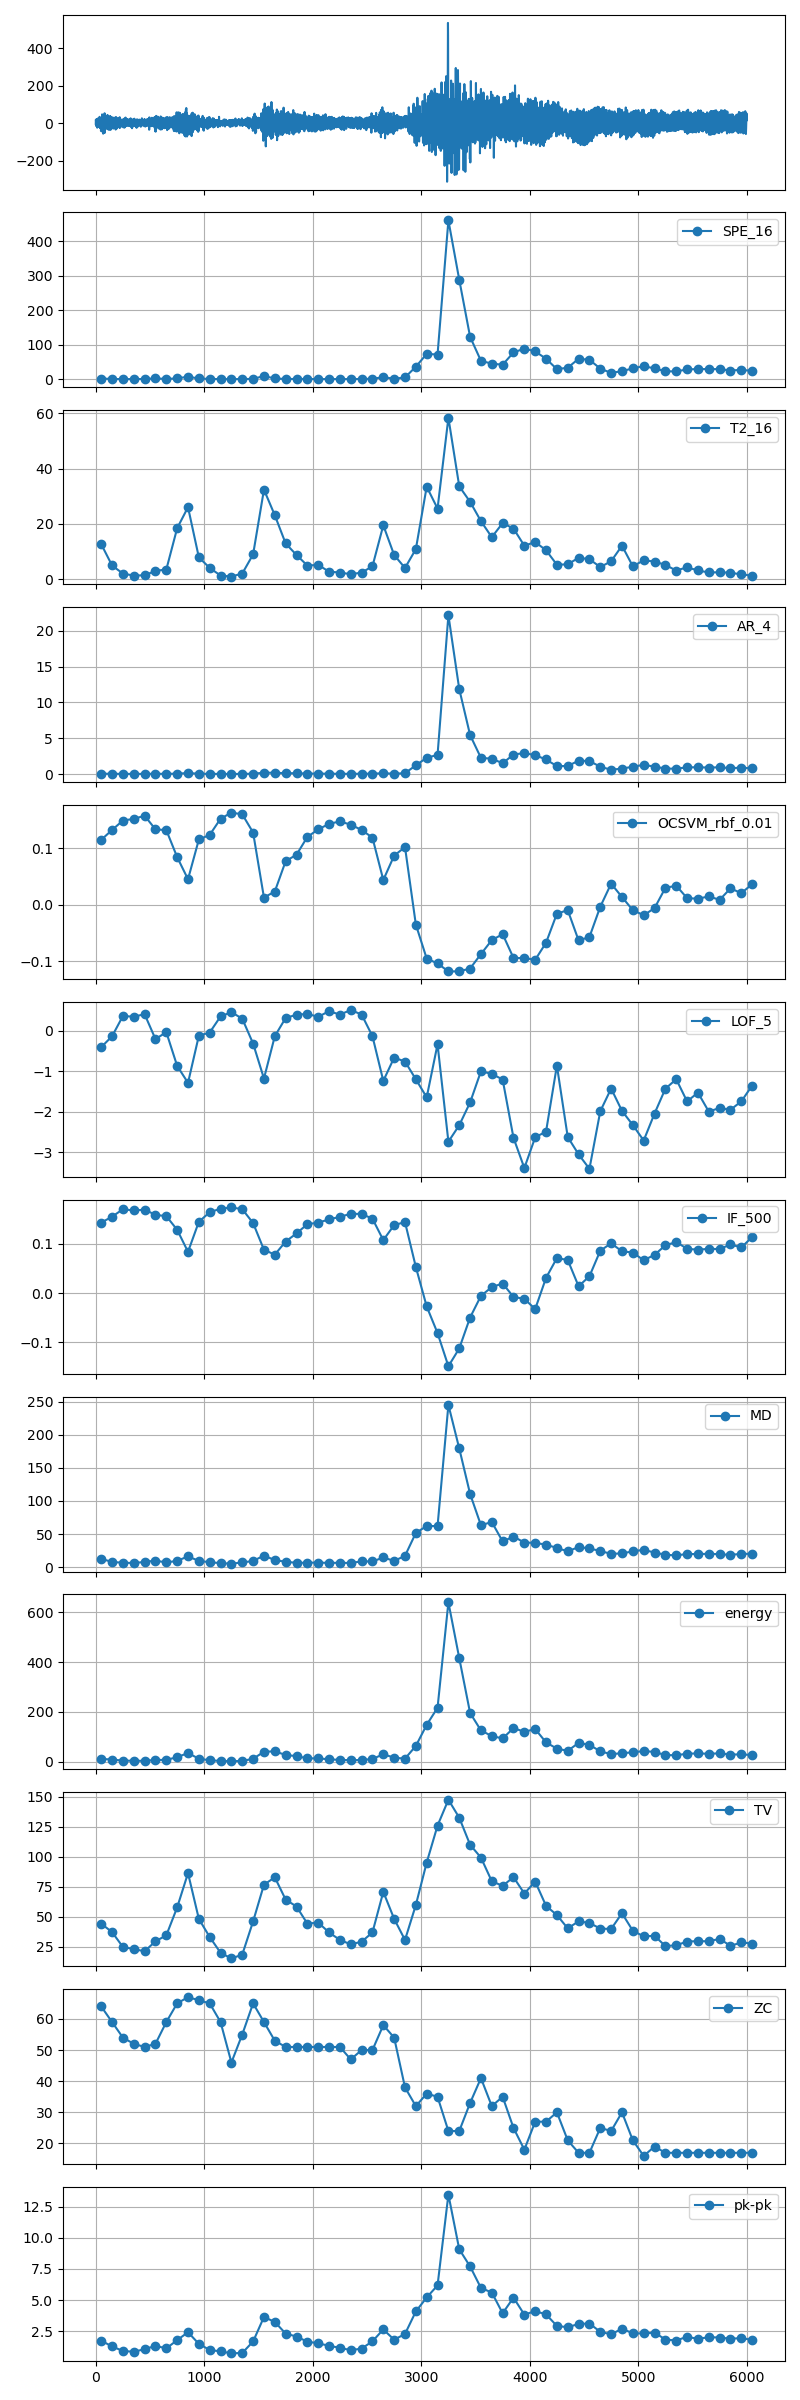

In [9]:
fig, ax = plt.subplots(1+scores_sliced_df.shape[1], 1, figsize=(8, 2*(scores_sliced_df.shape[1]+1)), sharex=True)
ax[0].plot(X_anom_series.loc[show_period[0]: show_period[1]].values)
for ax_, column in zip(ax[1:], scores_sliced_df.columns):
    ax_.plot(n//2 + n*np.arange(scores_sliced_df[column].shape[0]), scores_sliced_df[column].values, label=column, marker='o')
    ax_.legend()
    ax_.grid()
fig.tight_layout()